In [4]:
import iris

In [27]:
from distributed import Client

c = Client('172.31.18.5:8786')
c

<Client: scheduler="172.31.18.5:8786" processes=26 cores=26>

In [31]:
# one day of data is 2.7k files and approx 100GB
# iris loads about 1 file / sec / core
month = '01'
day = '01'
prefix = 'prods_op_mogreps-g_2016{}{}'.format(month, day)
prefix

'prods_op_mogreps-g_20160101'

In [19]:
from boto.s3.connection import S3Connection
import os

os.environ['S3_USE_SIGV4'] = 'True'

def list_files(bucket, prefix='prods'):
    conn = S3Connection(host='s3.eu-west-2.amazonaws.com')
    bucket = conn.get_bucket(bucket)
    results = []
    keys = iter(bucket.list(prefix=prefix))
    return ['/usr/local/share/notebooks/data/mogreps-g/{}'.format(k.key) for k in keys]


in_files = list_files('mogreps-g', prefix)
print(len(in_files))
in_files[:10]

2784


['/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_003.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_006.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_009.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_012.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_015.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_018.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_021.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_024.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_027.nc',
 '/usr/local/share/notebooks/data/mogreps-g/prods_op_mogreps-g_20160101_00_00_030.nc']

In [28]:
# create a dask bag (db). 
# What we end up with is a list of instructions to run the 'load_cubes' function on each input file.
from iris.cube import CubeList
from dask import delayed
import dask.bag as db

@delayed
def load_cubes(address):
    def add_realization(cube, field, filename):
        if not cube.coords('realization'):
            realization = int(filename.split('_')[-2])
            realization_coord = iris.coords.AuxCoord(realization, standard_name='realization')
            cube.add_aux_coord(realization_coord)
    return iris.load(address, callback=add_realization)

delayed_cubes = db.from_delayed([load_cubes(f) for f in in_files])
delayed_cubes

dask.bag<bag-fro..., npartitions=2784>

In [29]:
delayed_cubes.take(10)

(<iris 'Cube' of wet_bulb_potential_temperature / (K) (time: 2; pressure: 3; latitude: 600; longitude: 800)>,
 <iris 'Cube' of wet_bulb_freezing_level_altitude / (m) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (time: 2; pressure: 16; latitude: 600; longitude: 800)>,
 <iris 'Cube' of dew_point_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of fog_area_fraction / (1) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of geopotential_height / (m) (time: 2; pressure: 9; latitude: 600; longitude: 800)>)

In [30]:
cubes = c.persist(delayed_cubes)

In [32]:
cubes

dask.bag<bag-fro..., npartitions=2784>

In [34]:
cubes.filter(lambda x: 'temperature' in x.name()).take(20)

(<iris 'Cube' of wet_bulb_potential_temperature / (K) (time: 2; pressure: 3; latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (time: 2; pressure: 16; latitude: 600; longitude: 800)>,
 <iris 'Cube' of dew_point_temperature / (K) (latitude: 600; longitude: 800)>)

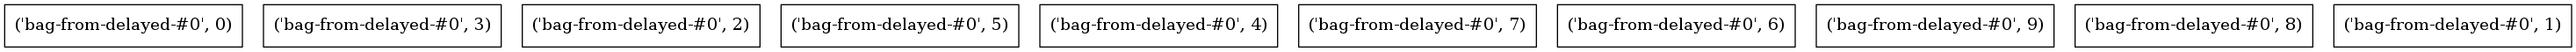

In [43]:
cubes.visualize()

In [35]:
names = list(set(cubes.map(lambda x: x.name())))
names

['air_temperature',
 'high_type_cloud_area_fraction',
 'relative_humidity',
 'air_pressure_at_sea_level',
 'wet_bulb_freezing_level_altitude',
 'low_type_cloud_area_fraction',
 'stratiform_snowfall_amount',
 'fog_area_fraction',
 'surface_downward_eastward_stress',
 'wet_bulb_potential_temperature',
 'dew_point_temperature',
 'surface_downward_northward_stress',
 'x_wind',
 'visibility_in_air',
 'stratiform_rainfall_amount',
 'geopotential_height',
 'y_wind',
 'wind_speed_of_gust',
 'medium_type_cloud_area_fraction']

In [43]:
stashes = list(set(cubes.map(lambda x: str(x.attributes['STASH']))))
stashes

['m01s03i236',
 'm01s15i202',
 'm01s03i463',
 'm01s03i250',
 'm01s03i226',
 'm01s03i225',
 'm01s16i222',
 'm01s16i256',
 'm01s00i003',
 'm01s03i248',
 'm01s15i201',
 'm01s16i203',
 'm01s00i002',
 'm01s16i202',
 'm01s04i202',
 'm01s09i221',
 'm01s16i205',
 'm01s09i205',
 'm01s03i281',
 'm01s04i201',
 'm01s09i203',
 'm01s03i219',
 'm01s09i204',
 'm01s03i220',
 'm01s03i245']

In [47]:
sample = cubes.filter(lambda x: str(x.attributes['STASH']) == stashes[0])
list(sample)

[<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of air_temperature / (K) (latitude: 6

In [48]:
cl = iris.cube.CubeList(sample)
cl

[<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (latitude: 600; longitude

In [49]:
cl.merge()

[<iris 'Cube' of air_temperature / (K) (time: 4; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (time: 4; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (time: 4; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (forecast_period: 57; forecast_reference_time: 4; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (-- : 228; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (-- : 228; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (-- : 44; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (-- : 44; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (-- : 44; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (-- : 2508; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (-- : 2508; latitude: 600; longitude: 800)>,
<iris 'Cube' of air_temperature / (K) (-- : 2508; latitude: 60

In [69]:
full_shape = set()
for cube in cl[:100]:
    full_shape.add(frozenset((len(c.points), type(c), c.standard_name) for c in cube.coords()))
full_shape

{frozenset({(1, iris.coords.DimCoord, 'forecast_period'),
            (1, iris.coords.DimCoord, 'forecast_reference_time'),
            (1, iris.coords.DimCoord, 'height'),
            (1, iris.coords.DimCoord, 'realization'),
            (1, iris.coords.DimCoord, 'time'),
            (600, iris.coords.DimCoord, 'latitude'),
            (800, iris.coords.DimCoord, 'longitude')})}

In [75]:
expected = set((len(c.points), type(c), c.standard_name) for c in cl[0].coords())

In [76]:
expected

{(1, iris.coords.DimCoord, 'forecast_period'),
 (1, iris.coords.DimCoord, 'forecast_reference_time'),
 (1, iris.coords.DimCoord, 'height'),
 (1, iris.coords.DimCoord, 'realization'),
 (1, iris.coords.DimCoord, 'time'),
 (600, iris.coords.DimCoord, 'latitude'),
 (800, iris.coords.DimCoord, 'longitude')}

In [88]:
bad = {(1, iris.coords.AuxCoord, 'forecast_period'),
 (1, iris.coords.DimCoord, 'forecast_reference_time'),
 (1, iris.coords.DimCoord, 'height'),
 (1, iris.coords.DimCoord, 'realization'),
 (1, iris.coords.DimCoord, 'time'),
 (600, iris.coords.DimCoord, 'latitude'),
 (800, iris.coords.DimCoord, 'longitude')}
bad == expected

False

In [81]:
for c in cl:
    actual = set((len(c.points), type(c), c.standard_name) for c in cl[0].coords())
    assert(actual == expected)
print('yay')

yay


In [89]:
expected_lat = cl[0].coord('latitude')
expected_lon = cl[0].coord('longitude')
expected_lat, expected_lon

(DimCoord(array([-89.84999847, -89.54999542, -89.25      , -88.94999695,
        -88.65000153, -88.34999847, -88.04999542, -87.75      ,
        -87.44999695, -87.15000153, -86.84999847, -86.54999542,
        -86.25      , -85.94999695, -85.65000153, -85.34999847,
        -85.04999542, -84.75      , -84.44999695, -84.15000153,
        -83.84999847, -83.54999542, -83.25      , -82.94999695,
        -82.65000153, -82.34999847, -82.04999542, -81.75      ,
        -81.44999695, -81.1499939 , -80.84999847, -80.54999542,
        -80.25      , -79.94999695, -79.6499939 , -79.34999847,
        -79.04999542, -78.75      , -78.44999695, -78.1499939 ,
        -77.84999847, -77.54999542, -77.25      , -76.94999695,
        -76.6499939 , -76.34999847, -76.04999542, -75.75      ,
        -75.44999695, -75.1499939 , -74.84999847, -74.54999542,
        -74.25      , -73.94999695, -73.6499939 , -73.34999847,
        -73.04999542, -72.75      , -72.44999695, -72.1499939 ,
        -71.84999847, -71.54999

In [90]:
for c in cl:
    assert(expected_lat == c.coord('latitude'))
    assert(expected_lon == c.coord('longitude'))
    
print('yay')

yay


In [93]:
expected_height = cl[0].coord('height')
expected_height

DimCoord(array([ 1.5]), standard_name='height', units=Unit('m'), var_name='height', attributes={'positive': 'up'})

In [95]:
for c in cl:
    assert(expected_height == c.coord('height'))
    
print('yay')

yay


In [96]:
expected_time = cl[0].coord('time')
expected_time

DimCoord(array([ 403225.5]), bounds=array([[ 403227.,  403224.]]), standard_name='time', units=Unit('hours since 1970-01-01 00:00:00', calendar='gregorian'), var_name='time_1')

In [98]:
for c in cl[:100]:
    print(c.coord('time').bounds)

[[ 403227.  403224.]]
[[ 403227.  403224.]]
None
None
[[ 403230.  403224.]]
[[ 403230.  403224.]]
[[ 403233.  403224.]]
[[ 403233.  403224.]]
None
[[ 403236.  403224.]]
None
[[ 403236.  403224.]]
[[ 403239.  403224.]]
[[ 403239.  403224.]]
None
[[ 403242.  403224.]]
[[ 403242.  403224.]]
None
[[ 403245.  403224.]]
[[ 403245.  403224.]]
None
[[ 403248.  403224.]]
None
[[ 403248.  403224.]]
[[ 403251.  403224.]]
[[ 403251.  403224.]]
None
[[ 403254.  403224.]]
[[ 403254.  403224.]]
None
[[ 403257.  403224.]]
None
[[ 403257.  403224.]]
[[ 403260.  403224.]]
[[ 403260.  403224.]]
None
[[ 403263.  403224.]]
[[ 403263.  403224.]]
None
[[ 403266.  403224.]]
[[ 403266.  403224.]]
None
[[ 403269.  403224.]]
[[ 403269.  403224.]]
None
[[ 403272.  403224.]]
None
[[ 403272.  403224.]]
[[ 403275.  403224.]]
None
[[ 403275.  403224.]]
[[ 403278.  403224.]]
None
[[ 403278.  403224.]]
[[ 403281.  403224.]]
None
[[ 403281.  403224.]]
[[ 403284.  403224.]]
None
[[ 403284.  403224.]]
[[ 403287.  403224.]

In [52]:
import ipywidgets as widgets

def param(x):
    def f(y, filt=x):
        return filt in y.name()
    
    return list(cubes.filter(f))[:10]

widgets.interact(param, x=list(names))

[<iris 'Cube' of visibility_in_air / (m) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of visibility_in_air / (m) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of visibility_in_air / (m) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of visibility_in_air / (m) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of visibility_in_air / (m) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of visibility_in_air / (m) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of visibility_in_air / (m) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of visibility_in_air / (m) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of visibility_in_air / (m) (latitude: 600; longitude: 800)>,
 <iris 'Cube' of visibility_in_air / (m) (latitude: 600; longitude: 800)>]

In [36]:
sample = cubes.take(1)[0]

In [41]:
str(sample.attributes['STASH'])

'm01s09i221'